# Check TDI SOBHB generation versus fastBHB in LDC

In [1]:
#Module import
import os
import h5py
import logging
import scipy
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as un

import numpy.lib.recfunctions as recf


import lisaorbits

from lisainstrument import Instrument

from pytdi import Data
from pytdi.michelson import X1, Y1, Z1
from pytdi.michelson import X2, Y2, Z2

from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import from_file
from ldc.lisa.projection import ProjectedStrain
from ldc.waveform.waveform import HpHc
from ldc.common.series.timeseries import TimeSeries

path = "data/"

## Philippe's work
Goal is first to compute time domain TDI with lisainstrument.

In [13]:
dt = 5 # waveform sampling
t_max = 0.1 * 60*60*24*365.25 # time of observation = 0.1yr
t_min = 0
print(t_min, t_max)

0 3155760.0


In [16]:
# orbits
dto = 86400
N = int(t_max/dto)+2
L = 2.5e9 # m
o = lisaorbits.EqualArmlengthOrbits(L=L, dt=dto, size=N, tt_order=1)
if os.path.isfile(path+'orbits.h5') : os.system("rm "+path+'orbits.h5')
o.write(path+'orbits.h5')

print(f"N={N}")

#To be used in ldc
config = {'nominal_arm_length':L, "orbit_type":'file', 'filename':path+'orbits.h5'}
orbits = Orbits.type(config)

N=38


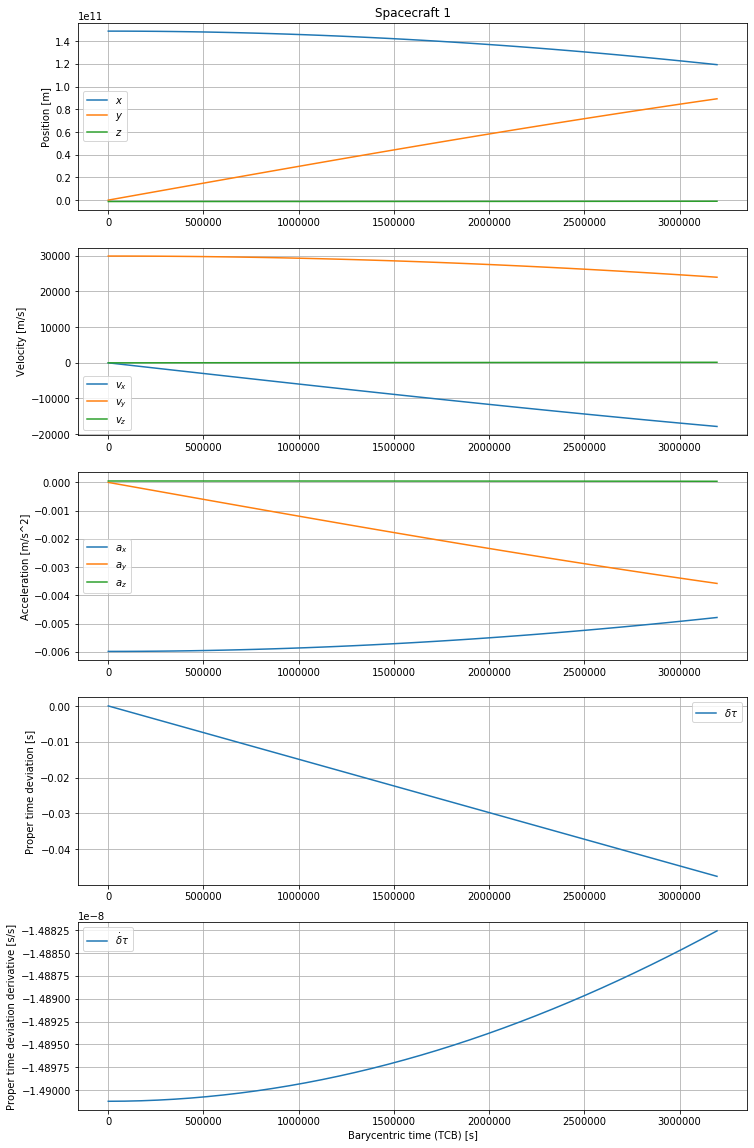

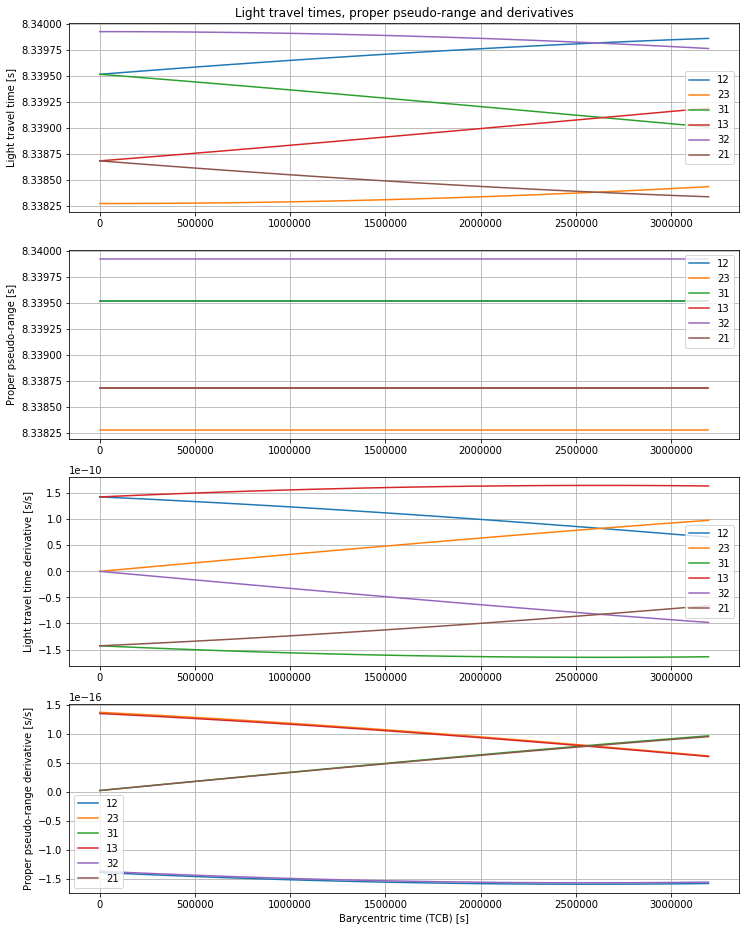

In [17]:
# plot orbits
o.plot_spacecraft(1)
o.plot_links()

In [18]:
logger = logging.getLogger('lisainstrument')
logger.setLevel(logging.INFO)

dt_instru = dt
physics_upsampling = 1
dt_physic = dt_instru/physics_upsampling

strain_filename = path+"sbbh-y.h5"
yArm, snames, links, tmin, tmax, dt = from_file(strain_filename)
tvec = np.arange(tmin, tmax, dt)

print(snames)
print(tmin, tmax, dt)
print(f"dt_instru={dt_instru} s | dt_physic={dt_physic}")

['sbbh.h5']
0.0 3155760.0 5.0
dt_instru=5 s | dt_physic=5.0


In [41]:
# write down the values of the straing + time vector
gw = {"t": np.arange(tmin, tmax+dt_physic, dt_physic)}
# gw = {"t": np.arange(tmin, tmax, dt_physic)}
print(gw["t"].size)

for j, n in enumerate(links):
    r,s = int(n[0]), int(n[-1])
    print(tvec.size, yArm[:,j].size)
    if dt != dt_physic:
#         gw[f"{r}{s}"] = scipy.interpolate.InterpolatedUnivariateSpline(tvec, yArm[:,j], k=5)(gw["t"])
        gw[f"{r}{s}"] = yArm[:,j]
    else:
        gw[f"{r}{s}"] = yArm[:,j]

631153
631152 631152
631152 631152
631152 631152
631152 631152
631152 631152
631152 631152


In [42]:
if physics_upsampling == 1:
    aafilter = None
else:
    aafilter = ('kaiser', 240, 1.1, 2.9)

N = int(tmax/dt_instru) # np.min([631100, int(tmax/dt_instru)])
print(f"aafilter={aafilter}")
print(f"N={N} | dt_instru={dt_instru}")
print(f"N*physics_upsampling={N*physics_upsampling}")

for k,v in gw.items():
    gw[k] = gw[k][0:int(N*physics_upsampling)]
    print(gw[k].shape)

aafilter=None
N=631152 | dt_instru=5
N*physics_upsampling=631152
(631152,)
(631152,)
(631152,)
(631152,)
(631152,)
(631152,)
(631152,)


In [43]:
orbit_filename = path+"orbits.h5"
i = Instrument(physics_upsampling=physics_upsampling, t0=tmin,
               aafilter=aafilter, size=N, dt=dt_instru,
               gws=gw, orbits=orbit_filename)

In [44]:
noisefree = True
lasernoise = False
doppler_effect = False
if noisefree:
    if lasernoise:
        i.disable_all_noises(but='laser')
    else:
        print(f"Disable all noises")
        i.disable_all_noises()
else:
    i.disable_clock_noises()
    
if not doppler_effect:
    print(f"Disabling doppler effect")
    i.disable_dopplers()
    
i.simulate()

assert np.allclose(i.t, tvec)

Disable all noises
Disabling doppler effect


In [45]:
# this cell takes a long time...
data = Data.from_instrument(i)
data.delay_derivative = None
# X2_data = X2.build(**data.args)
# Y2_data = Y2.build(**data.args)
# Z2_data = Z2.build(**data.args)
X2_data = X2.build(**data.args_nodoppler)
Y2_data = Y2.build(**data.args_nodoppler)
Z2_data = Z2.build(**data.args_nodoppler)

/home/esavalle/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


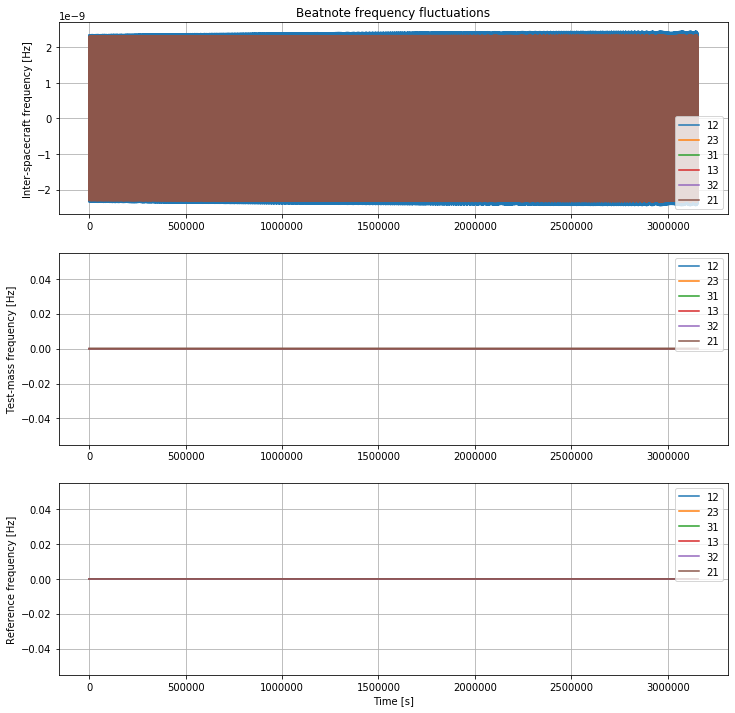

In [46]:
i.plot_fluctuations()

In [47]:
# see cell 27 of https://gitlab.in2p3.fr/LISA/LDC/-/blob/spritz/data_generation/spritz/demo.ipynb
central_freq = i.central_freq # 2.816E14
X2_pytdi = X2_data(data.measurements) / central_freq
Y2_pytdi = Y2_data(data.measurements) / central_freq
Z2_pytdi = Z2_data(data.measurements) / central_freq

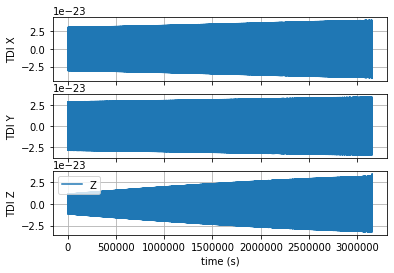

In [48]:
# plot TDI computed with lisainstruments
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(i.t, X2_pytdi, label="X")
ax[0].set_ylabel("TDI X")
ax[0].grid()

ax[1].plot(i.t, Y2_pytdi, label="Y")
ax[1].set_ylabel("TDI Y")
ax[1].grid()

ax[2].plot(i.t, Z2_pytdi, label="Z")
ax[2].set_xlabel("time (s)")
ax[2].set_ylabel("TDI Z")
ax[2].grid()

plt.legend()
plt.show()

In [49]:
# storing tdi in HDF5 file
# with h5py.File(args.output, 'w') as hdf5:
#     data = np.vstack((tvec, X2_ts, Y2_ts, Z2_ts)).T
#     hdf5.create_dataset('XYZ', data=data)

Now I compare the result with TDI generated by LDC pipeline routines with TDI2 (!)

In [51]:
Proj = ProjectedStrain(orbits)
Proj.from_file(path+"sbbh-y.h5")

assert np.allclose(Proj.yArm, yArm)
assert np.allclose(Proj.t_min, t_min)
assert np.allclose(Proj.t_max, t_max)

In [52]:
tdi2 = True
X2_ldc = TimeSeries(Proj.compute_tdi_x(tvec, tdi2=tdi2), dt=dt)
Y2_ldc = TimeSeries(Proj.compute_tdi_y(tvec, tdi2=tdi2), dt=dt)
Z2_ldc = TimeSeries(Proj.compute_tdi_z(tvec, tdi2=tdi2), dt=dt)

In [53]:
# compute overlaps
def overlap(x, y):
    xy_dot_term = np.dot(x, y)
    xx_dot_term = np.dot(x, x)
    yy_dot_term = np.dot(y, y)
    return xy_dot_term / np.sqrt(xx_dot_term * yy_dot_term)
    
O_tdi2_X = overlap(X2_pytdi, X2_ldc)
O_tdi2_Y = overlap(Y2_pytdi, Y2_ldc)
O_tdi2_Z = overlap(Z2_pytdi, Z2_ldc)

print(f"Overlap X= {O_tdi2_X}")
print(f"Overlap Y= {O_tdi2_Y}")
print(f"Overlap Z= {O_tdi2_Z}")

Overlap X= 0.9999432141979768
Overlap Y= 0.9998953443992217
Overlap Z= 0.9978633661163085


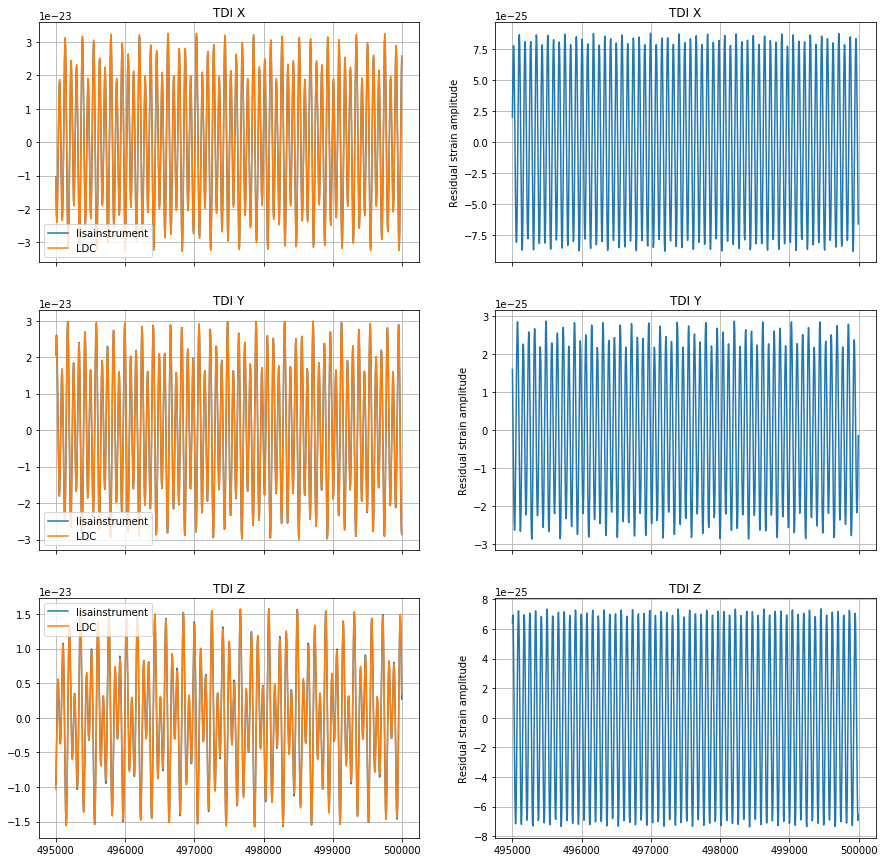

In [56]:
# a, b = 5000, 6000
a, b = 99000, 100000

fig, ax = plt.subplots(3, 2, sharex=True, figsize=(15, 15))

import numpy as np
for i_c,case in enumerate(["X","Y","Z"]) :
    ax[i_c,0].plot(i.t[a:b], eval(case+"2_pytdi[a:b]"), label="lisainstrument")
    ax[i_c,0].plot(tvec[a:b], eval(case+"2_ldc[a:b]"), label="LDC")
    ax[i_c,0].legend()
    ax[i_c,1].plot(i.t[a:b], eval(case+"2_pytdi[a:b]")-eval(case+"2_ldc[a:b]"))
    ax[i_c,1].set_ylabel("Residual strain amplitude")
    for i_p in range(2) :
        ax[i_c,i_p].set_title("TDI "+case)
        ax[i_c,i_p].grid()

plt.show()

Now I repeat the comparison with TDI1

In [58]:
X1_data = X1.build(**data.args_nodoppler)
Y1_data = Y1.build(**data.args_nodoppler)
Z1_data = Z1.build(**data.args_nodoppler)

In [59]:
X1_pytdi = X1_data(data.measurements) / central_freq
Y1_pytdi = Y1_data(data.measurements) / central_freq
Z1_pytdi = Z1_data(data.measurements) / central_freq

In [60]:
tdi2 = False
X1_ldc = TimeSeries(Proj.compute_tdi_x(tvec, tdi2=tdi2), dt=dt)
Y1_ldc = TimeSeries(Proj.compute_tdi_y(tvec, tdi2=tdi2), dt=dt)
Z1_ldc = TimeSeries(Proj.compute_tdi_z(tvec, tdi2=tdi2), dt=dt)

In [61]:
# compute overlaps
def overlap(x, y):
    xy_dot_term = np.dot(x, y)
    xx_dot_term = np.dot(x, x)
    yy_dot_term = np.dot(y, y)
    return xy_dot_term / np.sqrt(xx_dot_term * yy_dot_term)
    
O_tdi1_X = overlap(X1_pytdi, X1_ldc)
O_tdi1_Y = overlap(Y1_pytdi, Y1_ldc)
O_tdi1_Z = overlap(Z1_pytdi, Z1_ldc)

print(f"Overlap X= {O_tdi1_X}")
print(f"Overlap Y= {O_tdi1_Y}")
print(f"Overlap Z= {O_tdi1_Z}")

Overlap X= 0.9999291379179425
Overlap Y= 0.9998977578253118
Overlap Z= 0.9980782568755981


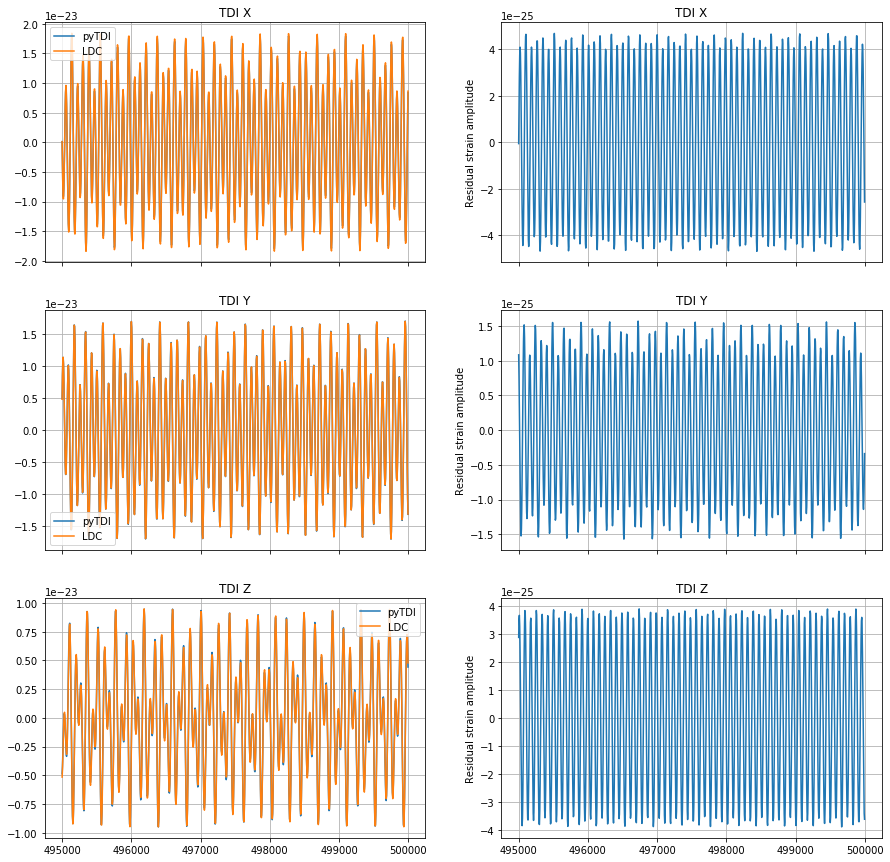

In [65]:
# a, b = 5000, 6000
a, b = 99000, 100000

fig, ax = plt.subplots(3, 2, sharex=True, figsize=(15, 15))

import numpy as np
for i_c,case in enumerate(["X","Y","Z"]) :
    ax[i_c,0].plot(i.t[a:b], eval(case+"1_pytdi[a:b]"), label="pyTDI")
    ax[i_c,0].plot(tvec[a:b], eval(case+"1_ldc[a:b]"), label="LDC")
    ax[i_c,0].legend()
    ax[i_c,1].plot(i.t[a:b], eval(case+"1_pytdi[a:b]")-eval(case+"1_ldc[a:b]"))
    ax[i_c,1].set_ylabel("Residual strain amplitude")
    for i_p in range(2) :
        ax[i_c,i_p].set_title("TDI "+case)
        ax[i_c,i_p].grid()

plt.show()

## Fast BHB check

In [33]:
#Module import
import os
import numpy as np
import matplotlib.pylab as plt
import astropy.units as un

from ldc.common.series.timeseries import FrequencySeries,TimeSeries
from ldc.io.hdf5.hdf5 import load_array
from ldc.common import constants
from ldc.lisa import orbits
from ldc.waveform.lisabeta import FastBHB
from ldc.common.series import TDI, AET2XYZ
from ldc.lisa.projection import ProjectedStrain
from ldc.waveform.waveform import HpHc

path = "data/"
YRSID_SI = constants.Nature.SIDEREALYEAR_J2000DAY*24*60*60

Saving Philippe's work to make it easier to work.

In [16]:
#Saving the data
if not os.path.isfile(path+"pytdi_tXYZ_1.npy") :
    np.save(path+"pytdi_tXYZ_1.npy",(i.t,X1_pytdi,Y1_pytdi,Z1_pytdi))
if not os.path.isfile(path+"pytdi_tXYZ_2.npy") :
    np.save(path+"pytdi_tXYZ_2.npy",(i.t,X2_pytdi,Y2_pytdi,Z2_pytdi))
if not os.path.isfile(path+"ldc_tXYZ_1.npy") :
    np.save(path+"ldc_tXYZ_1.npy",(i.t,X1_ldc,Y1_ldc,Z1_ldc))
if not os.path.isfile(path+"ldc_tXYZ_2.npy") :
    np.save(path+"ldc_tXYZ_2.npy",(i.t,X2_ldc,Y2_ldc,Z2_ldc))

### Time domain data

In [17]:
#Loading the data
t1_p,X1_p,Y1_p,Z1_p = np.load(path+"pytdi_tXYZ_1.npy")
t2_p,X2_p,Y2_p,Z2_p = np.load(path+"pytdi_tXYZ_2.npy")
t1_l,X1_l,Y1_l,Z1_l = np.load(path+"ldc_tXYZ_1.npy")
t2_l,X2_l,Y2_l,Z2_l = np.load(path+"ldc_tXYZ_2.npy")

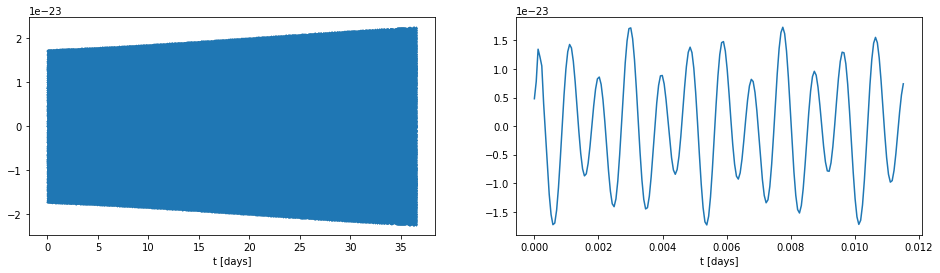

In [18]:
#Plotting a part of the data
fig,axs = plt.subplots(1,2,figsize=(16,4))
axs[0].plot(t1_p/86400,X1_p,".",ms=1)
axs[0].set_xlabel("t [days]")
axs[1].plot(t1_p[:200]/86400,X1_p[:200])
axs[1].set_xlabel("t [days]")
plt.show()

### Frequency domain data 

For the data analysis, we will use the data in the frequency domain.

In [27]:
#Compute frequency series from time domain data
dt1_p = np.diff(t1_p)[0]
X1_p_f = FrequencySeries(np.fft.ifft(X1_p)*dt1_p,df=1.0/(dt1_p * len(X1_p)))
dt2_p = np.diff(t2_p)[0]
X2_p_f = FrequencySeries(np.fft.ifft(X2_p)*dt2_p,df=1.0/(dt2_p * len(X2_p)))
dt1_l = np.diff(t1_l)[0]
X1_l_f = FrequencySeries(np.fft.ifft(X1_l)*dt1_l,df=1.0/(dt1_l * len(X1_l)))
dt2_l = np.diff(t2_l)[0]
X2_l_f = FrequencySeries(np.fft.ifft(X2_l)*dt2_l,df=1.0/(dt2_l * len(X2_l)))

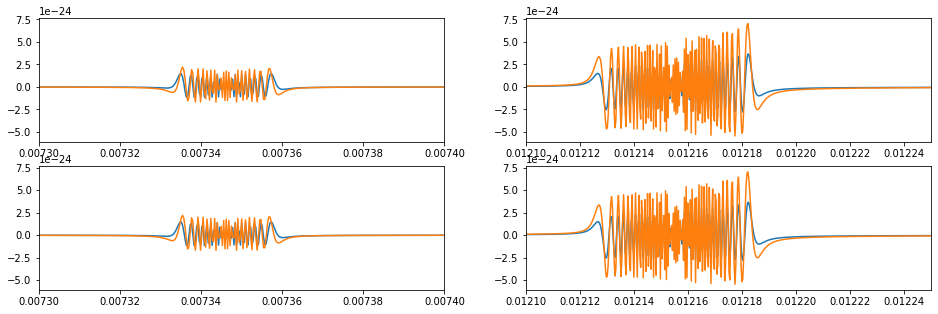

In [28]:
#Plot
fig,axs = plt.subplots(2,2,figsize=(16,5))
axs[0,0].plot(X1_p_f.f,X1_p_f.data,ms=3,label="pyTDI TDI1.5")
axs[0,0].plot(X2_p_f.f,X2_p_f.data,ms=3,label="pyTDI TDI2")
axs[0,0].set_xlim([0.0073,0.0074])
axs[0,1].plot(X1_p_f.f,X1_p_f.data,ms=3)
axs[0,1].plot(X2_p_f.f,X2_p_f.data,ms=3)
axs[0,1].set_xlim([0.0121,0.01225])
axs[1,0].plot(X1_p_f.f,X1_p_f.data,ms=3,label="pyTDI TDI1.5")
axs[1,0].plot(X2_p_f.f,X2_p_f.data,ms=3,label="pyTDI TDI2")
axs[1,0].set_xlim([0.0073,0.0074])
axs[1,1].plot(X1_p_f.f,X1_p_f.data,ms=3)
axs[1,1].plot(X2_p_f.f,X2_p_f.data,ms=3)
axs[1,1].set_xlim([0.0121,0.01225])
plt.show()

In [30]:
# load SBBH catalogue
path_cat = path+"sbbh.h5"
cat = load_array(path_cat)
cat[0]["ObservationDuration"] = 0.1*YRSID_SI
names = ['EclipticLatitude','EclipticLongitude','Mass1','Mass2','Spin1','Spin2',
        'Inclination','InitialFrequency','InitialPhase','Polarization',
        'Redshift','Distance','ObservationDuration','Cadence']
duration,dt = 0.1*YRSID_SI, 5
pSBHB = dict(zip(names, cat[0][1]))
lisa_orbits = orbits.Orbits.type(
    dict({"nominal_arm_length":2.5e9*un.m,
          "initial_rotation":0*un.rad,
          "initial_position":0*un.rad,
          "orbit_type":"analytic"})
)
approx = 'IMRPhenomD'

In [31]:
#Fast TDI
FBH = FastBHB("SOBHB", T=duration, delta_t=dt, approx=approx, orbits=lisa_orbits,)
A,E,T = FBH.get_fd_tdiaet(template=pSBHB, tdi2=True)
AET = TDI([A, E, T], ["A", "E", "T"])
XYZ_fast = AET2XYZ(AET)

In [34]:
#Slow TDI
hphc = HpHc.type("demo", "SOBHB", approx)
P = ProjectedStrain(lisa_orbits)
trange = np.arange(0, duration, dt)
hphc.set_param(pSBHB)
P.arm_response(0, duration, dt, [hphc])
X = TimeSeries(P.compute_tdi_x(trange, tdi2=True), dt=dt).ts.fft()
Y = TimeSeries(P.compute_tdi_y(trange, tdi2=True), dt=dt).ts.fft()
Z = TimeSeries(P.compute_tdi_z(trange, tdi2=True), dt=dt).ts.fft()
XYZ_slow = TDI([X, Y, Z], ["X", "Y", "Z"])

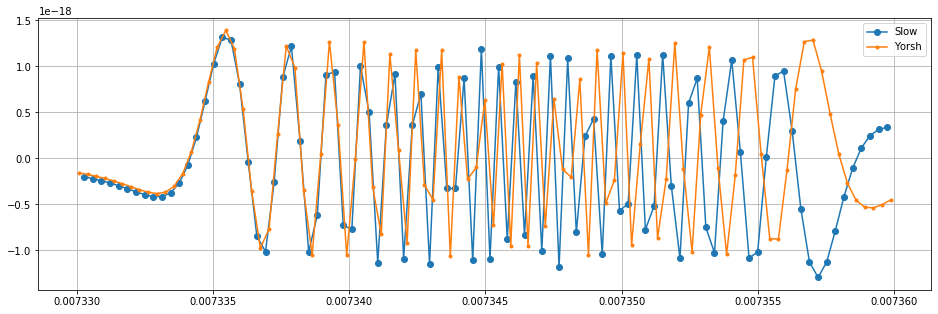

In [36]:
plt.figure(figsize=(16,5))
fs,ys = XYZ_slow["X"].f,XYZ_slow["X"]
fy,yy = X1_p_f.f,len(X2_p_f)*X2_p_f.data
ff,yf = 

fmin,fmax = 0.00733,0.00736
plt.plot(fs[(fmin<=fs)&(fs<=fmax)],ys[(fmin<=fs)&(fs<=fmax)],"o",ls="-",label="Slow")
plt.plot(fy[(fmin<=fy)&(fy<=fmax)],yy[(fmin<=fy)&(fy<=fmax)],"o",ls="-",ms=3,label="Yorsh")
#plt.plot(XYZ_fast["X"].f,XYZ_fast["X"],"o",ls="-",label="Fast")plt.grid(True)
plt.legend()
plt.show()